# Deep Q learning for continiuous spaces
In continuous space and in the case of this notebook, It is an image where occurs some changes by the agent or the environment itself. Treating this with a naive method won't get us a good result since a state at time t isn't relevant to estimate its reward. The solution is to get more than one state chronologically to estimate the reward of an action, then we need to store our actions and states in a memory to practice that.

# Import main libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# DeepQNetwork

In [3]:
class DQNetwork(nn.Module):
    def __init__(self,
                 lr,
                 input_dims,
                 fc1_dims,
                 fc2_dims,
                 fc3_dims,
                 nb_actions):
        super(DQNetwork, self).__init__()
        
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc2_dims
        self.nb_actions = nb_actions
        

        self.fc1= nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2= nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.fc3_dims)
        self.fc4 = nn.Linear(self.fc3_dims, self.nb_actions)

        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self,state):
        l1 = F.relu(self.fc1(state))
        l2 = F.relu(self.fc2(l1))
        # l3 = F.relu(self.fc3(l2))
        actions = self.fc4(l2) # don't activate the last layer
        
        return actions

# Agent class

In [4]:
class Agent():
    def __init__(self,
                 batch_size:float,
                 input_dims,
                 n_actions:int,
                 max_mem_size:int = 10_000,
                 gamma:float=0.99,
                 initial_eps:float=1.0,
                 final_eps:float=0.01,
                 eps_decay:float=1e-4,
                 lr:float=1e-4):
        self.gamma= gamma
        self.batch_size = batch_size
        self.input_dims = input_dims
        self.action_space = [i for i in range(n_actions)]
        self.eps_decay = eps_decay
        self.lr = lr
        self.eps = initial_eps
        self.eps_decay = eps_decay
        self.final_eps = final_eps
        self.mem_size = max_mem_size
        self.mem_counter = 0        
        self.sequence_length = 32  # You can adjust this value

        self.target_update_frequency = 100
        self.learn_step_counter = 0
        self.Q_eval = DQNetwork(lr=self.lr,
                                input_dims=self.input_dims,
                                nb_actions=n_actions,
                                fc1_dims=128, fc2_dims=128, fc3_dims=0)
        self.Q_target =  DQNetwork(lr=self.lr,
                                input_dims=self.input_dims,
                                nb_actions=n_actions,
                                fc1_dims=128, fc2_dims=128, fc3_dims=0)
        
        self.state_memory = np.zeros((self.mem_size, *self.input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *self.input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size,dtype=np.int32) # set of integers because our actions belong to a discrete space
        self.reward_memory = np.zeros(self.mem_size,dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size,dtype=bool)
    
    def store_transition(self, state, action, reward, state_, done): #sate_ : new state
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        
        self.mem_counter += 1
        

        
    def choose_action(self, obs ):
        if np.random.random() > self.eps :
            self.Q_eval.eval()  # Set to evaluation mode
            with T.no_grad():
                state = T.tensor(np.array([obs])).to(self.Q_eval.device)
                actions = self.Q_eval.forward(state)
            self.Q_eval.train()  # Set back to training mode
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        
        return action
        
    def learn(self):
        if self.mem_counter < self.batch_size:
            return 
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_size, self.mem_counter)  
        batch = np.random.choice(max_mem, size=self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        self.Q_target.eval()  # Set to evaluation mode
        with T.no_grad():
            q_next = self.Q_target.forward(new_state_batch)
        self.Q_target.train()  # Set back to training mode
     
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_frequency == 0:
            self.Q_target.load_state_dict(self.Q_eval.state_dict())
        
        self.eps = max((self.eps - self.eps_decay), self.final_eps)
        

8
Episode 0 score -369.7 avg score -369.7 epsilon 1.000
Episode 100 score -104.7 avg score -156.6 epsilon 0.906
Episode 200 score -11.9 avg score -149.9 epsilon 0.798
Episode 300 score -68.7 avg score -115.7 epsilon 0.681
Episode 400 score -19.0 avg score -122.3 epsilon 0.444
Episode 500 score -75.5 avg score 48.0 epsilon 0.050
Episode 600 score 280.3 avg score 133.6 epsilon 0.050
Episode 700 score 248.1 avg score 194.1 epsilon 0.050
Episode 800 score 272.7 avg score 177.3 epsilon 0.050
Episode 900 score 49.9 avg score 200.8 epsilon 0.050


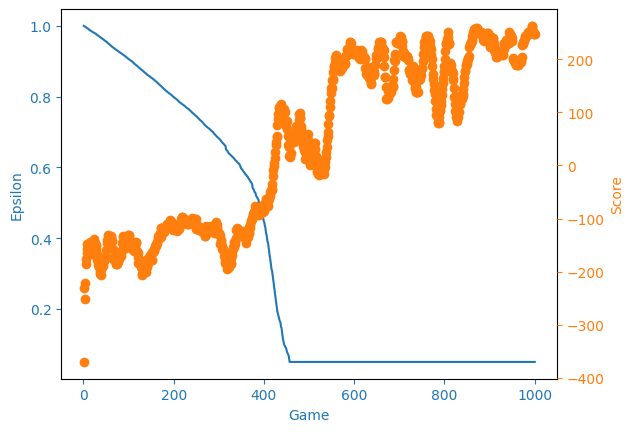

In [5]:
import gymnasium as gym
import numpy as np
from utils import plotLearning

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    print(env.observation_space.shape[0])
    agent = Agent(gamma=.99,
                  initial_eps=1.0,
                  eps_decay=1e-5,
                  final_eps=0.05,
                  batch_size=128,
                  n_actions=4,
                  input_dims=[8],
                  lr=0.0001,
                  max_mem_size=10_000)
    scores, eps_history = [],[]
    n_episodes = 1000
    j= n_episodes
    avg_score =-9999
    for i in range(n_episodes):
        score = 0
        done = False
        obs, info = env.reset()
        # if avg_score >-40 :
        #     j=i
        #     break
        while not done:
            action = agent.choose_action(obs)
            obs_, reward, terminated, truncated, info = env.step(action)
            score += reward
            agent.store_transition(obs, action, reward, obs_, done)
            agent.learn()
            obs = obs_
            done = terminated or truncated
        scores.append(score)
        eps_history.append(agent.eps)
        
        if i % 100 == 0:
                avg_score = np.mean(scores[-100:]) 
                print('Episode', i, 'score %.1f avg score %.1f epsilon %.3f'% (score, avg_score,agent.eps) )
    x = [i+1 for i in range(j)]
    filename = 'lunar_lander.png'
    plotLearning(x, scores,eps_history, filename)

In [6]:
import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg' if you prefer Qt
env = gym.make('LunarLander-v2', render_mode = 'rgb_array')
obs, info = env.reset()

plt.ion()
fig, ax = plt.subplots(figsize=(8,8))
action_text = ax.text(510, 20, '', color='white', fontsize=12, bbox=dict(facecolor='blue', alpha=0.8))
actions = ['nothing','Left','main','Right']
img = ax.imshow(env.render())
rewards = 0
num_epochs= 1000
for step in range(num_epochs):
    obs, info = env.reset()
    done = False
    while not done:
        action = agent.choose_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        rewards += reward
        frame = env.render()
        img.set_data(frame)
        action_text.set_text(f'Step: {actions[action] }')

        fig.canvas.draw()
        fig.canvas.flush_events()
        done = terminated or truncated
        obs = next_obs

plt.ioff()  # Turn off interactive mode
# plt.show()  # Keep the window open after the animation finishes
plt.close()
env.close()

TclError: can't invoke "update" command: application has been destroyed